<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Roman-Penzov-folder/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD_%D0%9F%D0%B5%D0%BD%D0%B7%D0%BE%D0%B2_%D0%A8%D0%90%D0%93_2_26_05_23_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ШАГ 2.**
Мысли нарастающим итогом:
1.   Как и на шаге 1 для первоначального решения задачи не стал вычищать базу, а оставил только файлы формата jpg и jpeg. Некоторые папки (виды одежды) удалил целиком. А уже на заключительных шагах буду использовать "исправленную/актуализированную" базу.
2.   Также хочу пробовать следующий алгоритм:
  *   сначала первая нейронка должна определить категорию одежды, к которой относится"картинка клиента". И почему бы для этого не использовать для первого варианта обычные сверточные нейронные сети. Иначе возможно попробовать вариант проверки на выброс.
  *   второй вид нейронки - это вариационный автокодировщик, который надо реализовать для каждой категории отдельно. Почему то думается, что так проще и эффективнее.


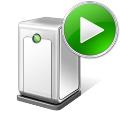

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Количество классов: 9, метки классов: ['dress  business', 'dress casual', 'dress homemade', 'dress solemn', 'shirt men', 'shirt women', 'sportswear women', 't-shirt men', 't-shirt women']


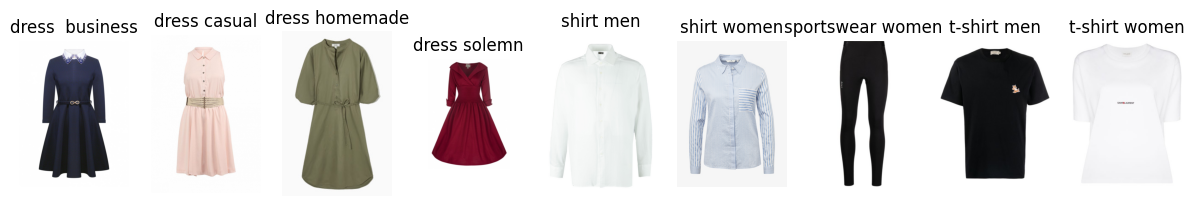

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import zipfile

# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Путь к архивному файлу
file_path = '/content/gdrive/MyDrive/test_230501.zip'

# Путь к директории, в которую нужно разархивировать файл
extract_path = '/content/selector'

# Разархивирование файла
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/selector/test_230501/'

# Получение списка папок, находящихся по адресу в скобках
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

# Отобразим визуально для примера по одному изображению из каждого класса
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(15, 15))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path)) 
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))  
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

# Загрузка и предобработка изображений из базы данных
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = image.load_img(
            os.path.join(folder, filename),
            target_size=(128, 128)  # Размер изображения для входа в автокодировщик
        )
        img = image.img_to_array(img)
        images.append(img)
    return np.array(images)

# Создание списка категорий товаров
categories = ['dress homemade']

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(IMAGE_PATH, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X.append(image)

# Преобразование списка в массив
X = np.array(X)

# Нормализация данных
X = X.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = np.zeros((X_train.shape[0], 128, 128, 3))
for i in range(X_train.shape[0]):
    resized_X_train[i] = resize(X_train[i], (128, 128))

resized_X_test = np.zeros((X_test.shape[0], 128, 128, 3))
for i in range(X_test.shape[0]):
    resized_X_test[i] = resize(X_test[i], (128, 128))

# Преобразование данных в правильный тип
resized_X_train = resized_X_train.astype('float32')
resized_X_test = resized_X_test.astype('float32')

In [ ]:
# Задаем размерность скрытого пространства
latent_dim = 32

# Определяем входное изображение
encoder_input = keras.Input(shape=(128, 128, 3))

# Создаем кодировщик
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Определяем параметры среднего и логарифма дисперсии распределения скрытого пространства
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Определяем сэмплирование из распределения скрытого пространства
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Сэмплируем скрытое пространство
z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Создаем декодировщик
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(decoder_input)
x = layers.Dense(32 * 32 * 64, activation="relu")(x)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# Создаем экземпляр кодировщика
encoder = Model(encoder_input, z_mean)

# Создаем экземпляр автоэнкодера
vae = Model([encoder_input, decoder_input], decoder_output)

# Определение функции потерь и оптимизатора
reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(encoder_input), K.flatten(decoder_output))
reconstruction_loss *= 128 * 128 * 3  # Размерность изображения
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

In [ ]:
# Обучение модели
history = vae.fit([resized_X_train, np.zeros((resized_X_train.shape[0], latent_dim))], epochs=10, batch_size=128, validation_data=([resized_X_test, np.zeros((resized_X_test.shape[0], latent_dim))], None))


Epoch 1/10
6/6 [==============================] - 1s 138ms/step - loss: 33221.4961 - val_loss: 33165.4219
Epoch 2/10
6/6 [==============================] - 1s 140ms/step - loss: 33143.3633 - val_loss: 33086.9180
Epoch 3/10
6/6 [==============================] - 1s 128ms/step - loss: 33065.6250 - val_loss: 33009.2734
Epoch 4/10
6/6 [==============================] - 1s 129ms/step - loss: 32989.0430 - val_loss: 32932.1953
Epoch 5/10
6/6 [==============================] - 1s 136ms/step - loss: 32913.3828 - val_loss: 32855.5234
Epoch 6/10
6/6 [==============================] - 1s 141ms/step - loss: 32838.3945 - val_loss: 32779.2812
Epoch 7/10
6/6 [==============================] - 1s 120ms/step - loss: 32763.0938 - val_loss: 32703.9551
Epoch 8/10
6/6 [==============================] - 1s 119ms/step - loss: 32688.7129 - val_loss: 32629.3516
Epoch 9/10
6/6 [==============================] - 1s 118ms/step - loss: 32615.2910 - val_loss: 32555.2949
Epoch 10/10
6/6 [=============================

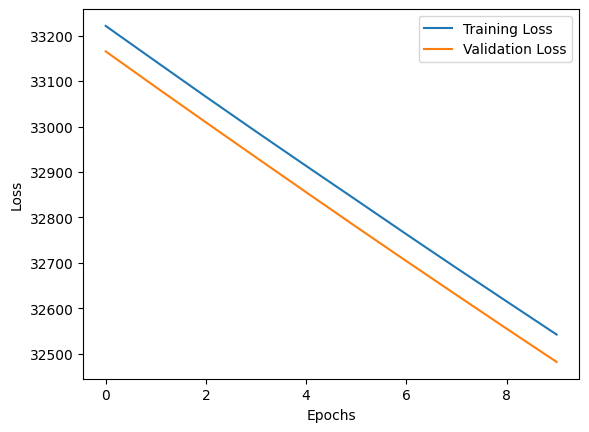

In [ ]:
# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step


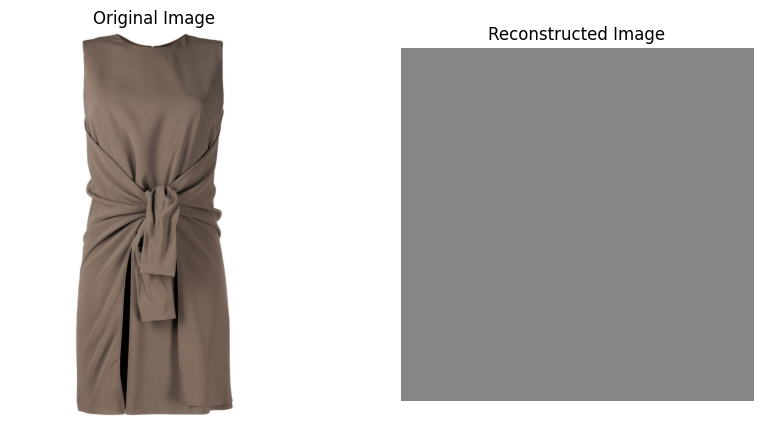

In [ ]:
import cv2

# Загрузка и предобработка изображения
image_path = "/content/selector/test/19643136_43915579_1000.jpg"  # Путь к изображению
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (128, 128))  # Приведение к нужному размеру
resized_image = resized_image / 255.0  # Нормализация значений пикселей

# Расширение размерности для входных данных
resized_image = np.expand_dims(resized_image, axis=0)

# Генерация случайной выборки из скрытого пространства
latent_sample = np.random.normal(size=(1, latent_dim))

# Восстановление изображения с помощью автокодировщика
reconstructed_image = vae.predict([resized_image, latent_sample])
reconstructed_image = reconstructed_image[0] * 255.0
reconstructed_image = reconstructed_image.astype(np.uint8)

# Визуализация оригинального и восстановленного изображений
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(reconstructed_image)
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")
plt.show()